## Mount Google Drive


In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [3]:
cd drive/My\ Drive/Colab\ Notebooks/voice_phishing/DL

/content/drive/My Drive/Colab Notebooks/voice_phishing/DL


In [4]:
# ls -l

# Import the Librairies

In [5]:
import numpy
from keras.preprocessing.text import Tokenizer
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,GRU, SimpleRNN
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.layers import Embedding
from keras.preprocessing.sequence import pad_sequences
from time import sleep
import string
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
import re
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(monitor = 'loss', verbose = 1,patience = 8, mode = 'min')
from glob import glob
import numpy as np
from tqdm import tqdm
# from keras.utils import to_categorical
# from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from keras.layers import Bidirectional, GlobalMaxPool1D
from sklearn.preprocessing import StandardScaler, RobustScaler
import os, re, csv, math, codecs
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from sklearn.metrics import classification_report

import tensorflow as tf

# Load the NPZ file and prepare it

In [6]:
npsavezFile=np.load("OLD_outfile-new.npz",allow_pickle=True)
#print(npsavezFile.files)
vocab=npsavezFile['arr_1']
data=npsavezFile['arr_0']
Y=npsavezFile['arr_2']
Y=list(Y)

max_length=max([len(i) for i in data])
#print("max_length",max_length) # max_length 35

#print(sorted([len(i) for i in data]))


word_id=dict((c,i) for i,c in enumerate(vocab))
id_word=dict((i,c) for i,c in enumerate(vocab))
#print("word_id",word_id)
#print("id_word",id_word)


X_train=[]
for sentence in data:
	x=[]
	for word in sentence:
		app=word_id[word]
		x.append(app)
		
	X_train.append(x)

In [7]:
max_length=max([len(i) for i in X_train])

encoded = pad_sequences(X_train, maxlen=max_length, padding='pre')
encoded=np.array(encoded)
#encoded=np.true_divide(encoded, 500)
#standard_scaler = StandardScaler()
#robust_scaler = RobustScaler()
#encoded = standard_scaler.fit_transform(encoded)
print("encoded shape",encoded.shape) #encoded shape (12924, 35)
length_encoded=len(encoded)

encoded shape (1218, 4855)


In [8]:
max_length

4855

# FastText embeddings


In [9]:
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open('wiki.ko.vec', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

MAX_NB_WORDS=len(vocab)
print('found %s word vectors' % len(embeddings_index))
print("tokenizing input data...")

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(data)  #leaky
word_seq_train = tokenizer.texts_to_sequences(data)
word_seq_test = tokenizer.texts_to_sequences(data)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))
embed_dim = 300 

loading word embeddings...


879131it [02:00, 7309.86it/s]


found 879130 word vectors
tokenizing input data...
dictionary size:  10024


In [24]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((MAX_NB_WORDS, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
print("sample words not found: ", np.random.choice(words_not_found, 10))

preparing embedding matrix...
number of null word embeddings: 23636
sample words not found:  ['주는거지' '해드릴려면' '이백에' '있으셨기' '결과지나' '녹취상태로' '법무팀만' '수고했어요' '넉넉' '해줘야지']


# Split dataset

In [25]:
from sklearn.model_selection import train_test_split
Y_train=np.array(Y)
# Split the data
trainX_data, testX_data, Y_TRAIN, Y_TEST = train_test_split(encoded, Y_train, test_size=0.30, shuffle= True)
Ytrain=to_categorical(Y_TRAIN,num_classes=2)
Ytest=to_categorical(Y_TEST,num_classes=2)

In [26]:
print('Train set size = {} \nTest set size = {}'.format(len(trainX_data),len(testX_data)))

Train set size = 12593 
Test set size = 5397


# Build the RNN model

In [27]:
from keras.callbacks import CSVLogger
csv_logger = CSVLogger('training_RNN_220414.log', separator=',', append=False)

In [28]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, embed_dim,weights=[embedding_matrix], input_length=max_length, trainable=False))
#model.add(Embedding(len(vocab), 10, input_length=max_length))
#model.add(LSTM(128,input_shape=(encoded.shape[0],encoded.shape[1]),return_sequences=True))
model.add(SimpleRNN(128,return_sequences=True))
model.add(Dropout(0.25))
model.add(SimpleRNN(128,return_sequences=True))
model.add(Dropout(0.25))
model.add(SimpleRNN(64,return_sequences=True))
model.add(Dropout(0.25))
model.add(SimpleRNN(64,return_sequences=True))
model.add(Dropout(0.20))
model.add(SimpleRNN(32))
model.add(Dropout(0.20))

model.add(Dense(2, activation='softmax'))
for i,layer in enumerate(model.layers):
 print("i",str(layer)+str(i))

print(model.summary())

i <keras.layers.embeddings.Embedding object at 0x7f5de1fce910>0
i <keras.layers.recurrent.SimpleRNN object at 0x7f5de203dcd0>1
i <keras.layers.core.dropout.Dropout object at 0x7f5dddbb77d0>2
i <keras.layers.recurrent.SimpleRNN object at 0x7f5de1fce9d0>3
i <keras.layers.core.dropout.Dropout object at 0x7f5dddb1ec90>4
i <keras.layers.recurrent.SimpleRNN object at 0x7f5ddda6f1d0>5
i <keras.layers.core.dropout.Dropout object at 0x7f5ddda6f4d0>6
i <keras.layers.recurrent.SimpleRNN object at 0x7f5dddbacb50>7
i <keras.layers.core.dropout.Dropout object at 0x7f5ddd9fb690>8
i <keras.layers.recurrent.SimpleRNN object at 0x7f5ddd9f3fd0>9
i <keras.layers.core.dropout.Dropout object at 0x7f5ddda55cd0>10
i <keras.layers.core.dense.Dense object at 0x7f5dddbb7250>11
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 808, 300)          13799400  
                     

In [29]:
# %%time
# for i,layer in enumerate(model.layers):
#     print("i",str(layer)+str(i))

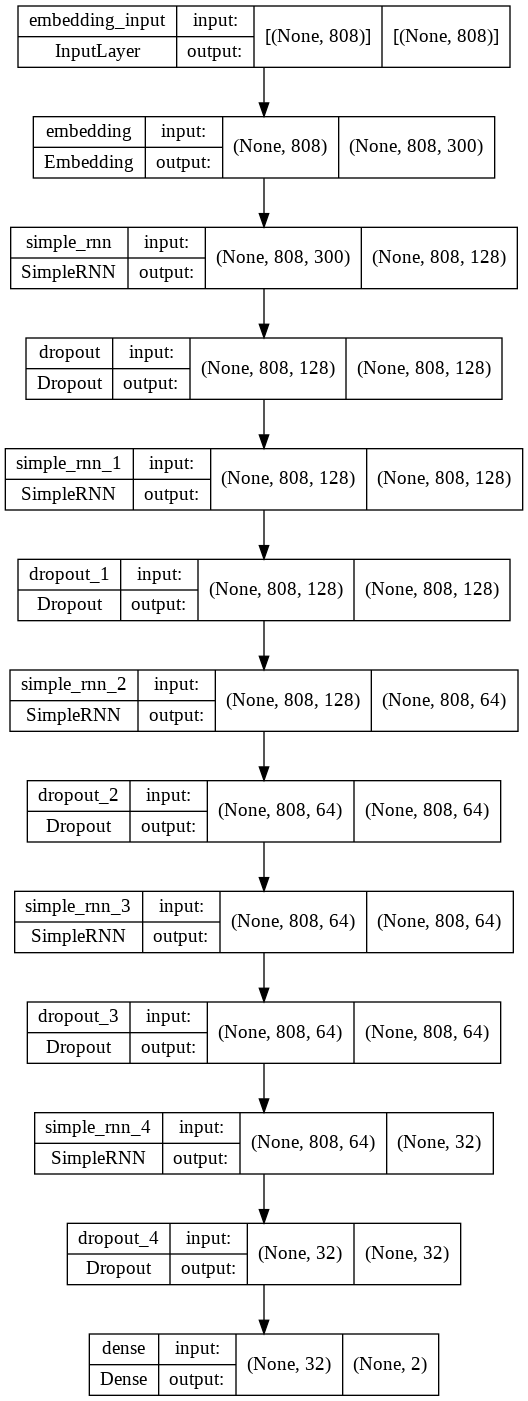

In [30]:
tf.keras.utils.plot_model(model, 
                          to_file="RNN_architecture.png",
                          show_shapes=True)

In [31]:
# tf.keras.utils.plot_model(
#     model,
#     to_file="RNN_architecture_1.png",
#     show_shapes=False,
#     # show_dtype=False,
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=False,
#     dpi=96,
# )

In [32]:
# %%time
# # print(model.summary())

In [1]:
# compile network
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', 
                      #  tf.keras.metrics.AUC(), 
                       tf.keras.metrics.Precision(), 
                       tf.keras.metrics.Recall()
                       ]
              )

NameError: ignored

# train the model and evaluation

In [ ]:
%%time
from time import time
from timeit import default_timer as timer

# fit network
filepath="best_weight.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint,earlystopping,csv_logger] #

start_time = time()
history = model.fit(trainX_data, 
                    Ytrain,batch_size=32, 
                    epochs=10, 
                    verbose=1,
                    callbacks=callbacks_list,
                    validation_data=(testX_data,Ytest)
                    )
run_time = time() - start_time

#for i,layer in enumerate(model.layers):
# print("i",str(layer)+str(i)) 


Epoch 1/10
394/394 [==============================] - ETA: 0s - loss: 0.2225 - accuracy: 0.9269 - precision: 0.9272 - recall: 0.9269
Epoch 1: loss improved from inf to 0.22250, saving model to best_weight.hdf5
394/394 [==============================] - 1482s 4s/step - loss: 0.2225 - accuracy: 0.9269 - precision: 0.9272 - recall: 0.9269 - val_loss: 0.1459 - val_accuracy: 0.9689 - val_precision: 0.9689 - val_recall: 0.9689
Epoch 2/10
394/394 [==============================] - ETA: 0s - loss: 0.1779 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570
Epoch 2: loss improved from 0.22250 to 0.17787, saving model to best_weight.hdf5
394/394 [==============================] - 1469s 4s/step - loss: 0.1779 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - val_loss: 0.1416 - val_accuracy: 0.9689 - val_precision: 0.9689 - val_recall: 0.9689
Epoch 3/10
394/394 [==============================] - ETA: 0s - loss: 0.1605 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650
Epoch 3: loss

In [ ]:
# graph of the training
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.legend()
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.xlabel('epochs')
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# graph of the training
plt.plot(history.epoch, history.history['loss'], '-o', label='training_loss')
plt.plot(history.epoch, history.history['val_loss'], '-o', label='validation_loss')
plt.legend()
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.grid(True)
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
# graph of the training
plt.plot(history.epoch, history.history['accuracy'], '-o', label='training_accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], '-o', label='validation_accuracy')
plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

#save the model

In [ ]:
model.load_weights(filepath)

In [ ]:
%%time
model.save("SIMPLERNN_10EP.h5")

# Test

In [ ]:
test_loss, test_acc = model.evaluate(testX_data)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

In [ ]:
#######################for testing####################

yhat_probs = model.predict(testX_data)
# predict crisp classes for test set
yhat_classes = model.predict_classes(testX_data)


# reduce to 1d array
#yhat_probs = yhat_probs[:, 0]
#yhat_classes = yhat_classes[:, 0]

# Metrics

In [ ]:
print(classification_report(Y_TEST, yhat_classes))

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_TEST, yhat_classes)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(Y_TEST, yhat_classes,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_TEST, yhat_classes,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_TEST, yhat_classes,average='weighted')
print('Testing F1 score: %f' % f1)

In [ ]:
# Setting up our results dataframe
df_results = pd.DataFrame(columns=['F1_score', 'Precision', 'Recall', 'Accuracy', 'Accuracy1', 'Training time'])

# append the results
df_results.loc['RNN'] = [f1, precision, recall, accuracy, accuracy, run_time]
df_results

## Save performances result to SVC file


In [ ]:
# save the training results
df_results.to_csv('performances_RNN_algorithm.csv')